In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import xml.etree.ElementTree as ET
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import time
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from pathlib import Path
from torchvision.transforms import ToTensor
import random
import cv2


In [ ]:
image_dir_check = r"D:\Торренты архив\Localization-segmentation dataset\PASCAL_VOC\VOC2012_train_val\VOC2012_train_val\JPEGImages"

for file in os.listdir(image_dir_check):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(image_dir_check, file)
        try:
            image = Image.open(img_path)
            print(f"{file}: {image.size}, {image.mode}")
        except Exception as e:
            print(f"Ошибка при открытии {file}: {e}")
            

In [3]:
class VOCImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, max_samples=None, shuffle=False):
        self.image_dir = Path(image_dir)
        self.annotation_dir = Path(annotation_dir)
        self.transform = transform
        self.image_files = list(self.image_dir.glob('*.jpg'))

        # Фильтруем только те изображения, для которых есть аннотации
        self.image_files = [img for img in self.image_files if self.annotation_exists(img)]

        # Ограничиваем количество загружаемых образцов
        if max_samples is not None:
            if shuffle:
                random.seed(42) 
                self.image_files = random.sample(self.image_files, max_samples)  # Случайная выборка
            else:
                self.image_files = self.image_files[:max_samples]  

    def annotation_exists(self, img_path):
        # Проверяем, существует ли аннотация для данного изображения
        annotation_file = self.annotation_dir / f"{img_path.stem}.xml"
        return os.path.exists(annotation_file)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")  # Открываем изображение

        # Загружаем аннотации
        annotation_file = self.annotation_dir / f"{img_path.stem}.xml"  # Получаем путь к XML файлу
        boxes, labels = self.parse_annotation(annotation_file)

        if self.transform:
            image = self.transform(image)

        return image, boxes, labels

    def parse_annotation(self, annotation_file):
        boxes = []
        labels = []

        if not os.path.exists(annotation_file):
            print(f"Предупреждение: файл аннотации не найден: {annotation_file}")
            return boxes, labels  # Возвращаем пустые списки

        try:
            tree = ET.parse(annotation_file)
        except ET.ParseError as e:
            print(f"Ошибка парсинга файла {annotation_file}: {e}")
            return boxes, labels  # Возвращаем пустые списки

        root = tree.getroot()
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(label)

            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))

            boxes.append([xmin, ymin, xmax, ymax])

        return boxes, labels

def parse_cropped_object_class(cropped_object_name, cropped_objects_dir):
    # Парсим XML-файл, чтобы получить класс объекта на основе имени файла
    xml_file_path = os.path.join(cropped_objects_dir, f"{cropped_object_name}.xml")
    
    if not os.path.exists(xml_file_path):
        print(f"Предупреждение: XML файл для {cropped_object_name} не найден.")
        return None
    
    try:
        tree = ET.parse(xml_file_path)
    except ET.ParseError as e:
        print(f"Ошибка парсинга файла {xml_file_path}: {e}")
        return None

    root = tree.getroot()
    # Предполагается, что класс объекта хранится в теге <Category>
    category_element = root.find('Category')
    if category_element is not None:
        return category_element.text.replace("Category:", "").strip()
    
    return None

    

In [4]:
import xml.etree.ElementTree as ET

def place_cropped_objects_on_images(dataset, cropped_objects_dir, output_image_dir, output_annotation_dir):
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_annotation_dir, exist_ok=True)

    # Считываем вырезанные объекты
    cropped_objects = {}
    for file in os.listdir(cropped_objects_dir):
        if file.endswith('.png'):
            cropped_object_name = file[:-4]  # Убираем расширение .png
            cropped_objects[cropped_object_name] = cv2.imread(os.path.join(cropped_objects_dir, file), cv2.IMREAD_UNCHANGED)  # Загружаем с альфа-каналом
            print(f"Загружен вырезанный объект: {cropped_object_name}")

    for idx in range(len(dataset)):
        img, boxes, labels = dataset[idx]

        # Преобразуем тензор в numpy массив и масштабируем
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        # Проверка на пустое изображение
        if img_np.size == 0:
            print(f"Ошибка: изображение {dataset.image_files[idx].name} пустое или неверного формата.")
            continue  # Пропускаем это изображение

        img_height, img_width = img_np.shape[:2]

        # Здесь мы будем добавлять новые метки и координаты для вырезанных объектов
        new_boxes = []
        new_labels = []

        # Случайное количество вырезанных объектов для добавления
        num_objects_to_add = random.randint(1, 2)  # например, добавляем от 1 до 2 объектов
        for _ in range(num_objects_to_add):
            label = random.choice(list(cropped_objects.keys()))
            cropped_img = cropped_objects[label]

            # Проверка, имеет ли вырезанный объект альфа-канал
            if cropped_img.shape[2] == 4:  # Если есть альфа-канал
                alpha_channel = cropped_img[:, :, 3]  # Получаем альфа-канал
                # Находим непрозрачные области
                non_transparent_indices = np.where(alpha_channel > 0)
                if non_transparent_indices[0].size == 0:
                    continue  # Пропускаем, если нет непрозрачных пикселей

                # Получаем минимальные и максимальные индексы
                ymin, ymax = non_transparent_indices[0].min(), non_transparent_indices[0].max()
                xmin, xmax = non_transparent_indices[1].min(), non_transparent_indices[1].max()

                # Вычисляем размеры видимой части
                visible_height = ymax - ymin + 1
                visible_width = xmax - xmin + 1

                # Обрезаем изображение до видимой части
                cropped_img_rgb = cv2.cvtColor(cropped_img[ymin:ymax + 1, xmin:xmax + 1, :3], cv2.COLOR_BGR2RGB)
                alpha_channel = alpha_channel[ymin:ymax + 1, xmin:xmax + 1] / 255.0  # Нормализуем альфа-канал
            else:
                cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB
                visible_height, visible_width = cropped_img.shape[:2]  # Если нет альфа-канала, используем полные размеры
                alpha_channel = np.ones((visible_height, visible_width))  # Полностью непрозрачный

            # Проверка на корректность размещения
            if visible_height > img_height or visible_width > img_width:
                print(f"Ошибка: вырезанный объект {label} больше изображения {dataset.image_files[idx].name}. Пропускаем.")
                continue  # Пропускаем этот объект

            # Случайное размещение
            x_offset = random.randint(0, img_width - visible_width)
            y_offset = random.randint(0, img_height - visible_height)

            # Наложение вырезанного объекта на изображение с учетом альфа-канала
            for c in range(3):  # Для каждого канала RGB
                img_np[y_offset:y_offset + visible_height, x_offset:x_offset + visible_width, c] = (
                    img_np[y_offset:y_offset + visible_height, x_offset:x_offset + visible_width, c] * (1 - alpha_channel) +
                    cropped_img_rgb[:, :, c] * alpha_channel
                )

            # Получаем класс объекта из XML-файла
            object_class = parse_cropped_object_class(label, cropped_objects_dir)
            if object_class is not None:
                new_boxes.append([x_offset, y_offset, x_offset + visible_width, y_offset + visible_height])
                new_labels.append(object_class)  # Используем класс вместо имени файла

        # Объединяем старые и новые метки и координаты
        boxes.extend(new_boxes)
        labels.extend(new_labels)

        # Сохраняем измененное изображение
        output_image_path = os.path.join(output_image_dir, f"{dataset.image_files[idx].name}")
        cv2.imwrite(output_image_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))  # Сохраняем в формате BGR
        print(f"Сохранено изображение: {output_image_path}")

        # Сохраняем обновленные аннотации
        output_annotation_path = os.path.join(output_annotation_dir, f"{dataset.image_files[idx].stem}.xml")
        save_updated_annotation(output_annotation_path, boxes, labels)

def save_updated_annotation(output_file, boxes, labels):
    root = ET.Element("annotation")
    for box, label in zip(boxes, labels):
        obj = ET.SubElement(root, "object")
        name = ET.SubElement(obj, "name")
        name.text = label

        bndbox = ET.SubElement(obj, "bndbox")
        xmin = ET.SubElement(bndbox, "xmin")
        xmin.text = str(box[0])
        ymin = ET.SubElement(bndbox, "ymin")
        ymin.text = str(box[1])
        xmax = ET.SubElement(bndbox, "xmax")
        xmax.text = str(box[2])
        ymax = ET.SubElement(bndbox, "ymax")
        ymax.text = str(box[3])

    tree = ET.ElementTree(root)
    tree.write(output_file)


In [6]:
# Нормализация и аугментация данных
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Преобразование в градации серого
    # transforms.Resize((500, 500)),  # Изменение размера для модели
    transforms.ToTensor(),
    # transforms.Resize((720, 720)),  # Увеличиваем размер для последующей обрезки
    # transforms.RandomCrop(500),  # Обрезаем центральную часть
    # transforms.RandomCrop(600),  # Дополнительно 
    # transforms.ColorJitter(brightness=0.6, contrast=0.4, saturation=0.7, hue=0.4),
    # transforms.RandomPosterize(bits=2),  # Случайное уменьшение глубины цвета
    # transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    # transforms.RandomRotation(10),  # Случайное вращение на угол
    # transforms.ConvertImageDtype(torch.float32),  # Преобразование изображения в тип float32
    # transforms.Normalize(mean=[0.2088, 0.2088, 0.2090], std=[0.0364, 0.0364, 0.0377])  # Нормализация
 ])

In [7]:
# Пример использования
train_image_dir = r"D:\Торренты архив\Localization-segmentation dataset\PASCAL_VOC\VOC2012_train_val\VOC2012_train_val\JPEGImages"
train_annotation_dir = r"D:\Торренты архив\Localization-segmentation dataset\PASCAL_VOC\VOC2012_train_val\VOC2012_train_val\Annotations"
test_image_dir = r"D:\Торренты архив\Localization-segmentation dataset\PASCAL_VOC\VOC2012_test\VOC2012_test\JPEGImages"
test_annotation_dir = r"D:\Торренты архив\Localization-segmentation dataset\PASCAL_VOC\VOC2012_test\VOC2012_test\Annotations"

In [8]:
# Создаем датасет с ограничением на количество образцов
max_train_samples = 9500
max_test_samples = 3500
train_dataset = VOCImageDataset(train_image_dir, train_annotation_dir, transform=transform, max_samples=max_train_samples, shuffle=True)
test_dataset = VOCImageDataset(test_image_dir, test_annotation_dir, transform=transform, max_samples=max_test_samples, shuffle=True)

# Проверяем количество загруженных образцов
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of samples in dataset: {len(test_dataset)}")

Number of samples in dataset: 9500
Number of samples in dataset: 3500


In [17]:
# Функция для отображения изображений и аннотаций
def show_images(dataset, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        image, boxes, labels = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Изменяем порядок осей для отображения
        image = np.clip(image, 0, 1)  # Ограничиваем значения для корректного отображения

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)

        # Формируем строку с метками
        labels_text = '\n'.join(labels)  # Разделяем метки новой строкой
        # plt.title(f"Image {i + 1}\nLabels:\n{labels_text}", fontsize=10, pad=5)  # Уменьшаем размер шрифта
        plt.axis('off')

    plt.show()

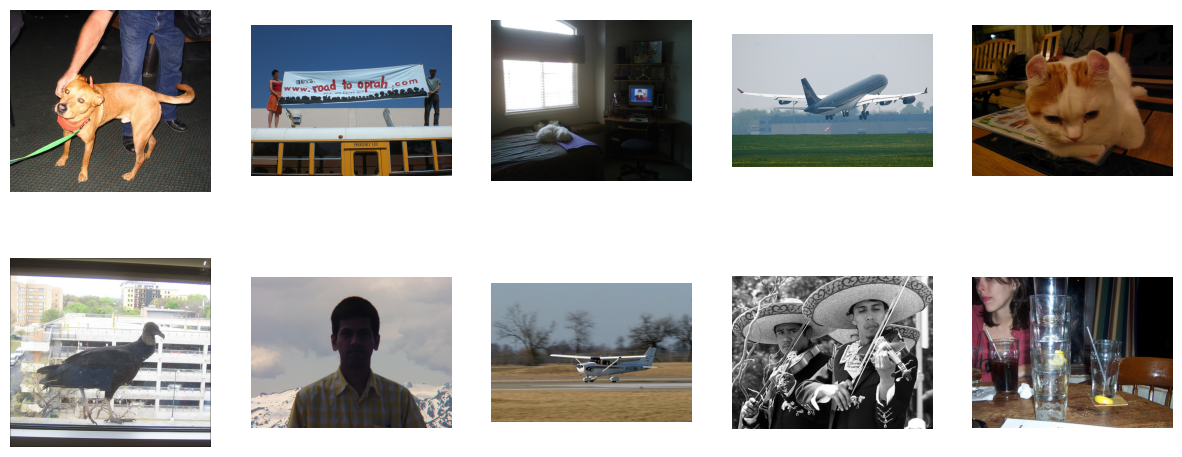

In [18]:
# Отображаем 5 изображений из датасета
show_images(train_dataset, num_images=10)
# Отображаем 5 изображений из датасета
#show_images(test_dataset, num_images=10)

In [21]:
output_image_dir_train = r"C:\Users\User\Desktop\Deep Learning\New_Dataset_for_YOLO\train\OutputImages"
output_annotation_dir_train = r"C:\Users\User\Desktop\Deep Learning\New_Dataset_for_YOLO\train\OutputAnnotations"
output_image_dir_test = r"C:\Users\User\Desktop\Deep Learning\New_Dataset_for_YOLO\test\OutputImages"
output_annotation_dir_test = r"C:\Users\User\Desktop\Deep Learning\New_Dataset_for_YOLO\test\OutputAnnotations"
cropped_objects_dir_train = r"C:\Users\User\Desktop\Deep Learning\Cropped_Objects2\train"
cropped_objects_dir_test = r"C:\Users\User\Desktop\Deep Learning\Cropped_Objects2\test"

In [ ]:
# Переносим вырезанные объекты на изображения и обновляем аннотации
place_cropped_objects_on_images(train_dataset, cropped_objects_dir_train, output_image_dir_train, output_annotation_dir_train)
place_cropped_objects_on_images(test_dataset, cropped_objects_dir_test, output_image_dir_test, output_annotation_dir_test)

Загружен вырезанный объект: cropped_object_10002_0_engine_part_cooler_round
Загружен вырезанный объект: cropped_object_10005_0_thread
Загружен вырезанный объект: cropped_object_10007_0_injection_pump
Загружен вырезанный объект: cropped_object_10011_0_injection_pump
Загружен вырезанный объект: cropped_object_10016_0_engine_part_cooler_square
Загружен вырезанный объект: cropped_object_10017_0_engine_part_cooler_square
Загружен вырезанный объект: cropped_object_1001_0_clamp_small
Загружен вырезанный объект: cropped_object_10024_0_engine_part_cooler_round
Загружен вырезанный объект: cropped_object_10025_0_engine_part_cooler_round
Загружен вырезанный объект: cropped_object_1002_0_injection_pump
Загружен вырезанный объект: cropped_object_10032_0_tee_connector
Загружен вырезанный объект: cropped_object_10036_0_thread
Загружен вырезанный объект: cropped_object_10038_0_adapter_plate_triangular
Загружен вырезанный объект: cropped_object_10041_0_engine_part_cooler_square
Загружен вырезанный объек

In [47]:
# Функция для отображения изображений и аннотаций
def show_images_2(dataset, num_images=5):
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        image, boxes, _ = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Изменяем порядок осей для отображения
        image = np.clip(image, 0, 1)  # Ограничиваем значения для корректного отображения

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

In [48]:
# Создаем датасет с ограничением на количество образцов
max_train_samples = 100
pictures_dataset = VOCImageDataset(output_image_dir_train, output_annotation_dir_train, transform=transform, max_samples=max_train_samples, shuffle=True)


# Проверяем количество загруженных образцов
print(f"Number of samples in dataset: {len(pictures_dataset)}")

Number of samples in dataset: 100


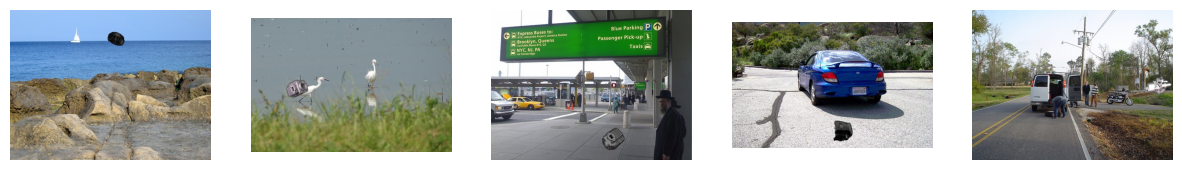

In [46]:
show_images_2(pictures_dataset, num_images=5)